In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter, splitter_train_val_test

In [5]:
from DataSets import UNetDataSetFromNpz, UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [8]:
epochs=50
coeff_mask = 0.75

In [9]:
model_name = "../model/trained_cUNet_pytorch_regression_{}epochs_coeff_mask{}_validation_on_npz_notranspose.pkl".format(epochs, coeff_mask)

In [10]:
model_inference = cUNet(out_size=1)

In [11]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Test trained model on 15mm

In [13]:
dataset_folder = os.path.join(data_dir,"dataset", "second_batch")

In [14]:
composed = transforms.Compose([Cut(),Rescale(.25), ChannelsFirst(), ToTensor()])

In [15]:
complete_dataset = UNetDatasetFromFolders(dataset_folder, transform=composed)

In [16]:
len(complete_dataset)

3000

In [17]:
dataset_loader = DataLoader(complete_dataset, batch_size=16, shuffle=True, num_workers=4)

In [18]:
model_inference.eval()
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

batch 1
1: true_dist: 35, pred_dist: [29.45696]


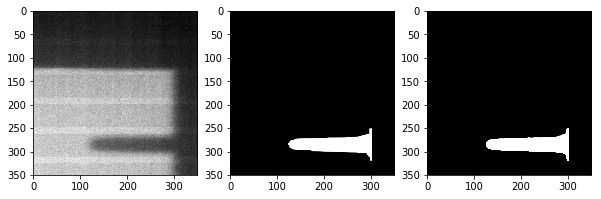

2: true_dist: 2, pred_dist: [2.030955]


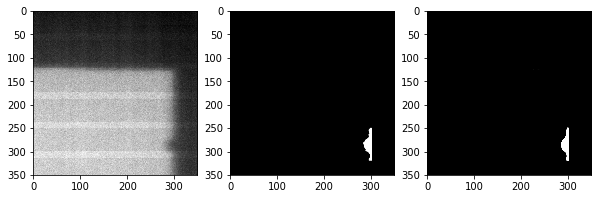

3: true_dist: 4, pred_dist: [3.8854642]


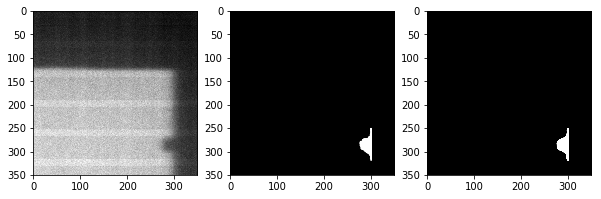

4: true_dist: 3, pred_dist: [2.570847]


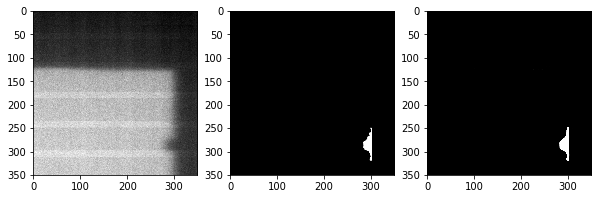

5: true_dist: 25, pred_dist: [25.168852]


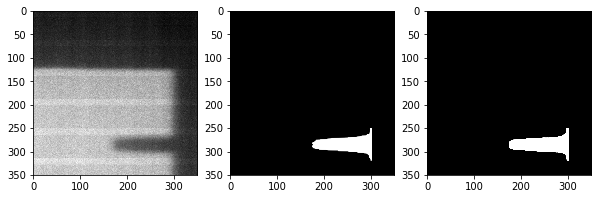

6: true_dist: 15, pred_dist: [15.417673]


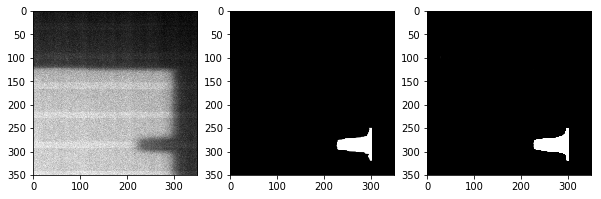

7: true_dist: 1, pred_dist: [1.1370295]


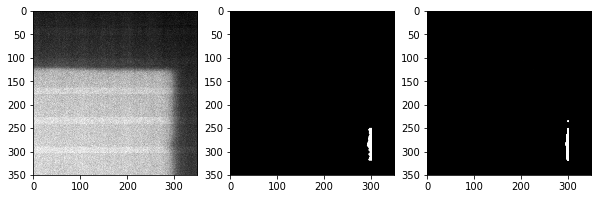

8: true_dist: 15, pred_dist: [15.575859]


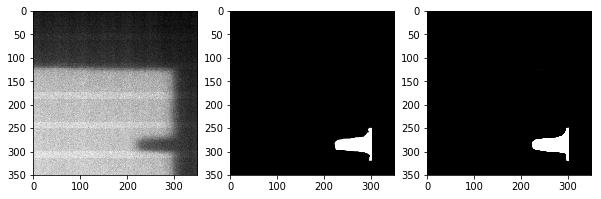

9: true_dist: 35, pred_dist: [30.168522]


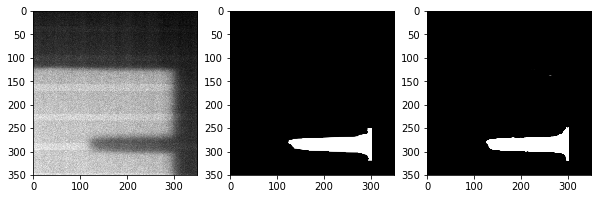

10: true_dist: 1, pred_dist: [1.2032462]


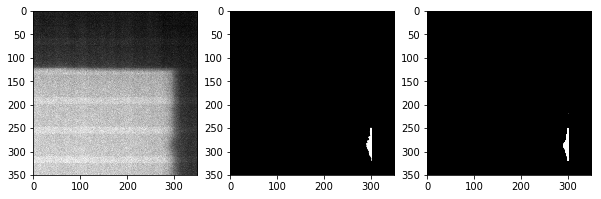

11: true_dist: 10, pred_dist: [9.897708]


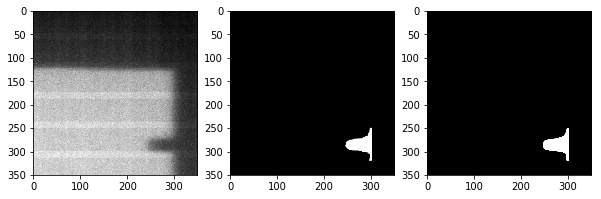

12: true_dist: 2, pred_dist: [1.9237398]


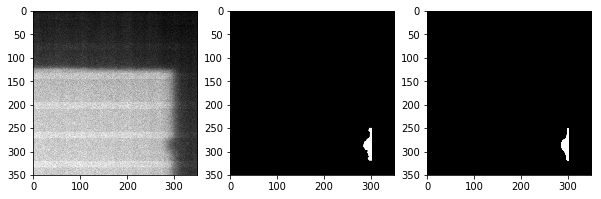

13: true_dist: 30, pred_dist: [27.76076]


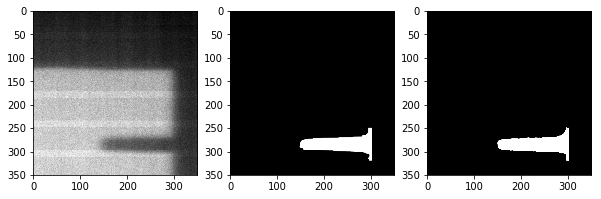

14: true_dist: 15, pred_dist: [15.457614]


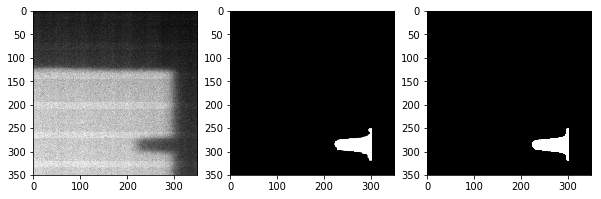

15: true_dist: 3, pred_dist: [2.8266282]


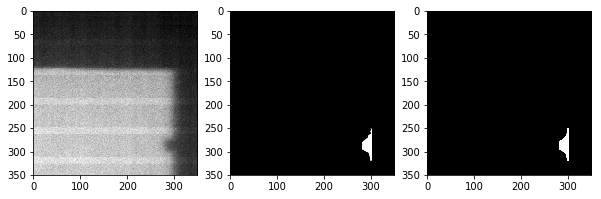

16: true_dist: 30, pred_dist: [28.079256]


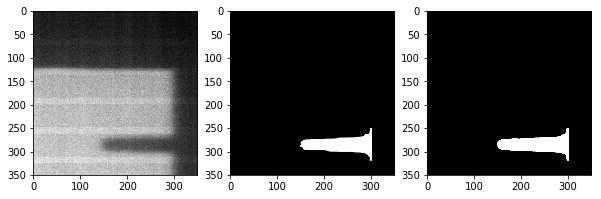

batch 2
1: true_dist: 15, pred_dist: [15.274785]


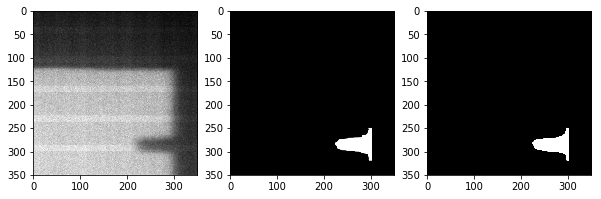

2: true_dist: 20, pred_dist: [20.606884]


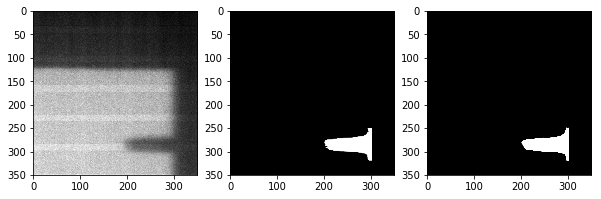

3: true_dist: 1, pred_dist: [1.2533201]


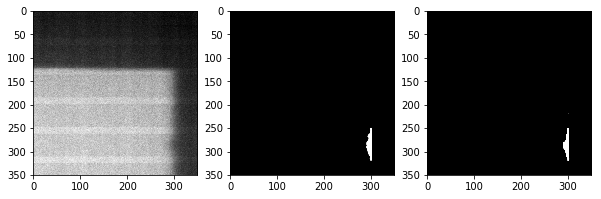

4: true_dist: 35, pred_dist: [29.40455]


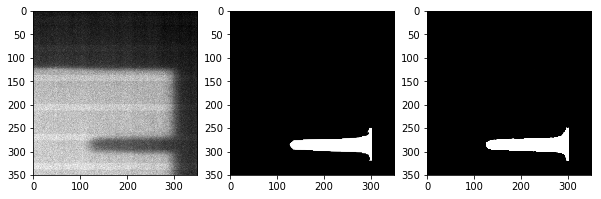

5: true_dist: 15, pred_dist: [15.598209]


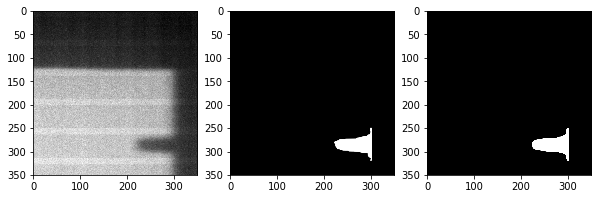

6: true_dist: 1, pred_dist: [1.2173373]


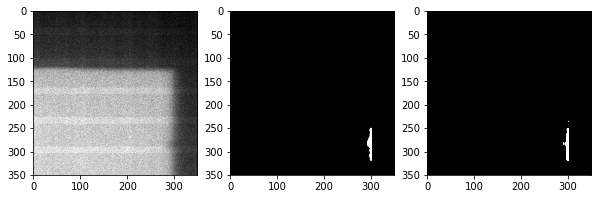

7: true_dist: 15, pred_dist: [15.375582]


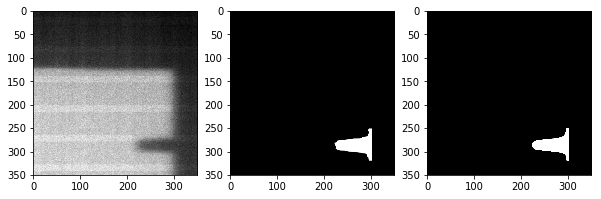

8: true_dist: 10, pred_dist: [9.863911]


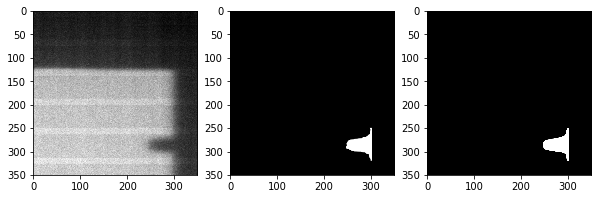

9: true_dist: 3, pred_dist: [2.7349832]


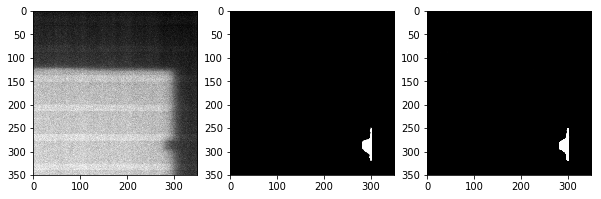

10: true_dist: 3, pred_dist: [2.6791356]


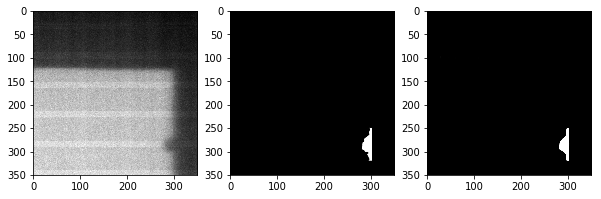

11: true_dist: 15, pred_dist: [15.322296]


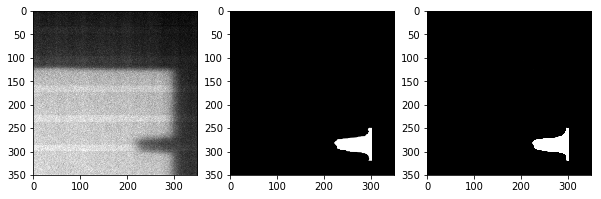

12: true_dist: 20, pred_dist: [20.97117]


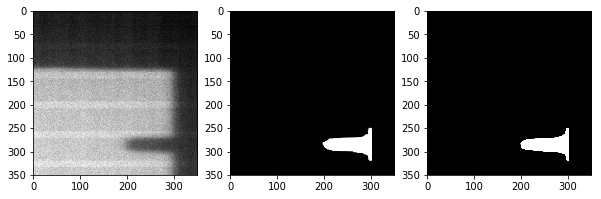

13: true_dist: 4, pred_dist: [3.8558073]


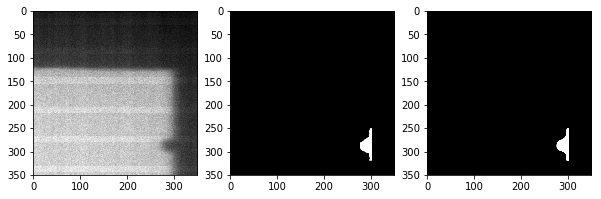

14: true_dist: 2, pred_dist: [1.9506533]


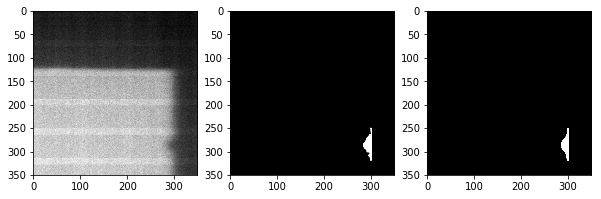

15: true_dist: 20, pred_dist: [21.001644]


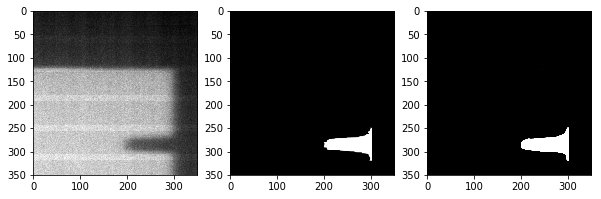

16: true_dist: 30, pred_dist: [27.894897]


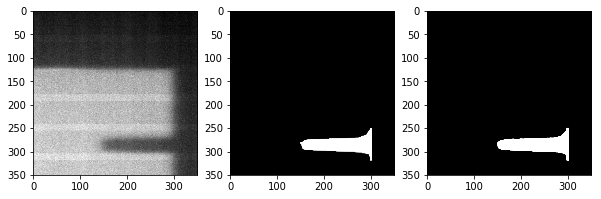

In [19]:
for i, batch in enumerate(dataset_loader):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [20]:
y_true = []
y_pred = []

for i, batch in tqdm.tqdm(enumerate(dataset_loader)):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_classes.cpu().detach().numpy())):
        true_dist = tr_cl
        pred_dist = pr_cl
        y_true.append(true_dist)
        y_pred.append(pred_dist)




188it [03:27,  1.10s/it]


In [21]:
y_pred = np.asarray(y_pred).ravel()
y_true = np.asarray(y_true)

print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 3.6268284453031367


In [22]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [23]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [24]:
idx_1, mse_1 = idx_mse(1)
idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
idx_4, mse_4 = idx_mse(4)
idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
idx_20, mse_20 = idx_mse(20)
idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
idx_35, mse_35 = idx_mse(35)

1 0.047669783082311644
2 0.011488652310405408
3 0.10386994732428055
4 0.024462751353300782
10 0.06194110621572387
15 0.23357991636260522
20 0.7128458212068168
25 0.03900298658541336
30 4.11816778071854
35 30.91525570787197


In [25]:
distances = [1,2,3,4,10,15,20,25,30,35]

In [26]:
errors = [idx_mse(i)[1] for i in distances]

1 0.047669783082311644
2 0.011488652310405408
3 0.10386994732428055
4 0.024462751353300782
10 0.06194110621572387
15 0.23357991636260522
20 0.7128458212068168
25 0.03900298658541336
30 4.11816778071854
35 30.91525570787197


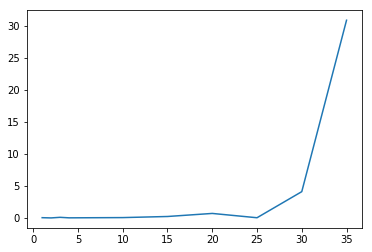

In [27]:
plt.plot(distances, errors)

#### let's round the numbers

In [28]:
y_pred_round = np.round(y_pred)

In [29]:
mean_squared_error(y_true, y_pred_round)

3.743333333333333

In [30]:
errors_round = [idx_mse(i, preds_arr=y_pred_round)[1] for i in distances]

1 0.0
2 0.0
3 0.06
4 0.0
10 0.03
15 0.37333333333333335
20 1.0066666666666666
25 0.006666666666666667
30 3.99
35 31.966666666666665


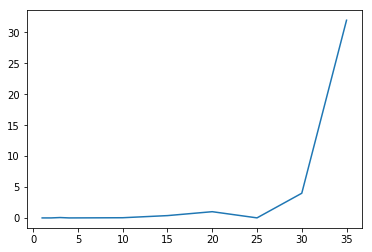

In [31]:
plt.plot(distances, errors_round)

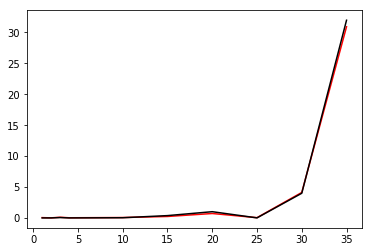

In [32]:
plt.plot(distances, errors, c='red')
plt.plot(distances, errors_round,c= 'k')

In [33]:
idx_30,mse_30 = idx_mse(30)
y_pred[idx_30]

30 4.11816778071854


array([27.776314, 28.209482, 27.910582, 27.92713 , 28.07731 , 28.0691  ,
       27.794853, 27.923208, 27.765287, 28.049755, 27.84914 , 28.359253,
       27.607784, 27.865631, 27.758247, 28.140245, 28.375366, 28.023727,
       27.807386, 28.055635, 28.23592 , 27.732525, 27.962801, 27.894897,
       27.633057, 27.578203, 28.445019, 28.02399 , 28.124043, 28.027565,
       27.818346, 28.059574, 27.864717, 27.714502, 28.180893, 28.163515,
       28.104588, 28.037674, 27.97733 , 27.840609, 28.148367, 27.610464,
       28.058983, 28.285395, 28.016256, 27.923409, 28.127403, 27.882713,
       28.016619, 27.9289  , 28.210423, 27.820478, 28.089096, 27.945961,
       27.90361 , 28.199617, 27.833363, 28.112997, 27.750214, 27.652546,
       27.8664  , 27.912508, 27.893198, 27.960394, 28.008417, 27.95712 ,
       28.019672, 27.829248, 28.113758, 27.624971, 28.178667, 27.842745,
       28.203197, 28.113163, 28.168118, 27.887001, 28.034779, 27.874977,
       28.243977, 28.404459, 27.99022 , 28.019289, 

In [34]:
idx_35,mse_35 = idx_mse(35)
y_pred[idx_35]

35 30.91525570787197


array([29.327112, 29.350128, 29.180595, 29.440388, 29.479761, 29.080488,
       29.970558, 29.464537, 29.919828, 29.697517, 29.65615 , 29.271301,
       29.713963, 29.376274, 29.256561, 29.340683, 29.44442 , 29.214281,
       29.057327, 29.312567, 29.58664 , 29.48769 , 29.834593, 29.19913 ,
       29.40447 , 29.413034, 29.503428, 29.241447, 29.749735, 29.36379 ,
       29.645695, 29.556595, 28.97489 , 29.389294, 29.398554, 29.342278,
       29.514269, 29.31284 , 29.514685, 29.903019, 29.433039, 29.543009,
       29.432465, 29.489109, 29.178164, 29.085016, 29.773603, 29.612503,
       29.829859, 29.11092 , 29.379778, 29.22448 , 29.042645, 28.893393,
       29.327915, 29.36691 , 29.271664, 29.342197, 29.57344 , 29.537607,
       30.146759, 29.24154 , 29.058456, 29.05685 , 29.489532, 29.284151,
       29.650213, 29.409264, 30.209867, 30.021559, 29.828505, 29.659006,
       29.611156, 29.20511 , 29.526382, 29.640976, 29.411049, 29.237123,
       29.551939, 29.775928, 29.701931, 29.43486 , 

In [35]:
idx_30_round,mse_30_round = idx_mse(30, preds_arr=y_pred_round)
y_pred_round[idx_30]

30 3.99


array([28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28

In [36]:
idx_35_round,mse_35_round = idx_mse(35, preds_arr=y_pred_round)
y_pred_round[idx_35]

35 31.966666666666665


array([29., 29., 29., 29., 29., 29., 30., 29., 30., 30., 30., 29., 30.,
       29., 29., 29., 29., 29., 29., 29., 30., 29., 30., 29., 29., 29.,
       30., 29., 30., 29., 30., 30., 29., 29., 29., 29., 30., 29., 30.,
       30., 29., 30., 29., 29., 29., 29., 30., 30., 30., 29., 29., 29.,
       29., 29., 29., 29., 29., 29., 30., 30., 30., 29., 29., 29., 29.,
       29., 30., 29., 30., 30., 30., 30., 30., 29., 30., 30., 29., 29.,
       30., 30., 30., 29., 29., 29., 29., 29., 29., 29., 30., 29., 29.,
       29., 29., 29., 29., 30., 29., 30., 29., 29., 29., 30., 29., 30.,
       30., 29., 29., 29., 29., 29., 29., 29., 29., 30., 30., 30., 29.,
       29., 29., 29., 30., 29., 29., 30., 30., 29., 29., 29., 30., 29.,
       30., 30., 30., 29., 29., 29., 29., 30., 29., 30., 29., 29., 30.,
       30., 29., 29., 29., 29., 29., 29., 29., 30., 29., 29., 29., 29.,
       30., 29., 30., 29., 29., 30., 30., 29., 30., 29., 29., 29., 30.,
       30., 29., 29., 29., 30., 30., 30., 29., 29., 30., 29., 30